In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import random

In [40]:
def load_vrp_file(filepath):
    node_coords = []
    demands = []
    capacity = 0
    
    section = None
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        line = line.strip()
        if not line: continue
        
        if line.startswith("CAPACITY"):
            capacity = int(line.split(":")[-1].strip())
        elif line.startswith("NODE_COORD_SECTION"):
            section = "COORD"
            continue
        elif line.startswith("DEMAND_SECTION"):
            section = "DEMAND"
            continue
        elif line.startswith("DEPOT_SECTION"):
            section = "DEPOT"
            continue
        elif line.startswith("EOF"):
            break
            
        if section == "COORD":
            parts = line.split()
            if len(parts) >= 3:
                node_coords.append([float(parts[1]), float(parts[2])])
        elif section == "DEMAND":
            parts = line.split()
            if len(parts) >= 2:
                demands.append(int(parts[1]))

    nodes = np.array(node_coords)
    demands = np.array(demands)
    dist_matrix = squareform(pdist(nodes))
    
    return nodes, demands, capacity, dist_matrix


file_path = 'A-VRP/A-n32-k5.vrp' 
nodes, demands, capacity, d_ij = load_vrp_file(file_path)


print(f"Dataset Loaded! Capacity: {capacity}, Nodes: {len(nodes)}")


Dataset Loaded! Capacity: 100, Nodes: 32


In [41]:
class Ant:
    def __init__(self, num_nodes, capacity, demands):
        self.num_nodes = num_nodes
        self.capacity = capacity
        self.demands = demands
        self.tour = []
        self.total_cost = 0.0
        self.visited_customers = set()

    def select_next_node(self, current_node, feasible_nodes, pheromone, heuristic, alpha, beta):
        probabilities = []
        denominator = 0.0

        for node in feasible_nodes:
            tau = pheromone[current_node][node] ** alpha
            eta = heuristic[current_node][node] ** beta
            prob_value = tau * eta
            probabilities.append(prob_value)
            denominator += prob_value

        if denominator == 0:
            return random.choice(feasible_nodes)
        
        probabilities = np.array(probabilities) / denominator
        
        next_node = np.random.choice(feasible_nodes, p=probabilities)
        return next_node

    def run_tour(self, dist_matrix, pheromone, heuristic, alpha, beta):
        current_node = 0
        self.tour = [0]
        self.visited_customers = set()
        current_load = 0
        
        while len(self.visited_customers) < (self.num_nodes - 1):
            
            feasible_nodes = []
            
            for node in range(1, self.num_nodes):
                if node not in self.visited_customers:
                    if current_load + self.demands[node] <= self.capacity:
                        feasible_nodes.append(node)
            
            if not feasible_nodes:
                if current_node != 0:
                    self.tour.append(0)
                    current_node = 0
                    current_load = 0
                    continue
                else:
                    break

            next_node = self.select_next_node(current_node, feasible_nodes, pheromone, heuristic, alpha, beta)
            
            self.tour.append(next_node)
            self.visited_customers.add(next_node)
            current_load += self.demands[next_node]
            current_node = next_node
        
        if self.tour[-1] != 0:
            self.tour.append(0)
            
        self.calculate_cost(dist_matrix)
        
    def calculate_cost(self, dist_matrix):
        self.total_cost = 0.0
        for i in range(len(self.tour) - 1):
            from_node = self.tour[i]
            to_node = self.tour[i+1]
            self.total_cost += dist_matrix[from_node][to_node]

In [42]:
num_ants = 30
num_iterations = 100
alpha = 3.0
beta = 1.0
evaporation_rate = 0.1
Q = 100


pheromone = np.ones((len(nodes), len(nodes)))


dist_matrix_safe = d_ij.copy()
np.fill_diagonal(dist_matrix_safe, 1e-10) 
heuristic = 1.0 / dist_matrix_safe

In [43]:
# --- Main ACO Loop ---

best_global_cost = float('inf')
best_global_tour = []
cost_history = []  # To store the best cost of each iteration for plotting

print("Starting ACO Optimization...")

for iteration in range(num_iterations):
    ants = []
    
    # 1. Construct Solutions: Create ants and let them build tours
    for _ in range(num_ants):
        ant = Ant(len(nodes), capacity, demands)
        ant.run_tour(d_ij, pheromone, heuristic, alpha, beta)
        ants.append(ant)
        
    # 2. Find the best ant in this iteration
    # Sort ants by cost (ascending) -> Index 0 is the best
    ants.sort(key=lambda x: x.total_cost)
    best_ant_iter = ants[0]
    
    # 3. Update Global Best
    if best_ant_iter.total_cost < best_global_cost:
        best_global_cost = best_ant_iter.total_cost
        best_global_tour = best_ant_iter.tour
        print(f"Iteration {iteration + 1}: New Best Cost found = {best_global_cost:.2f}")
    
    # Store for convergence plot
    cost_history.append(best_global_cost)
    
    # 4. Pheromone Update
    # Step A: Evaporation (Decrease pheromone on all edges)
    pheromone *= (1 - evaporation_rate)
    
    # Step B: Deposit (Add pheromone to edges visited by ants)
    # Strategy: All ants deposit pheromone proportional to solution quality
    for ant in ants:
        deposit_amount = Q / ant.total_cost
        for i in range(len(ant.tour) - 1):
            u = ant.tour[i]
            v = ant.tour[i+1]
            # Since it is an undirected graph, update both directions
            pheromone[u][v] += deposit_amount
            pheromone[v][u] += deposit_amount

print("\nOptimization Finished!")
print(f"Final Best Cost: {best_global_cost:.2f}")
print(f"Final Best Tour Sequence: {best_global_tour}")

Starting ACO Optimization...
Iteration 1: New Best Cost found = 1436.92
Iteration 2: New Best Cost found = 1376.35
Iteration 3: New Best Cost found = 1258.61
Iteration 4: New Best Cost found = 1089.87
Iteration 6: New Best Cost found = 974.34
Iteration 9: New Best Cost found = 899.02
Iteration 13: New Best Cost found = 844.73
Iteration 24: New Best Cost found = 838.70

Optimization Finished!
Final Best Cost: 838.70
Final Best Tour Sequence: [0, 27, 24, 14, 26, 30, 16, 1, 0, 20, 5, 25, 10, 15, 9, 22, 8, 18, 29, 0, 7, 21, 31, 19, 17, 13, 0, 6, 3, 2, 23, 28, 11, 4, 0, 12, 0]


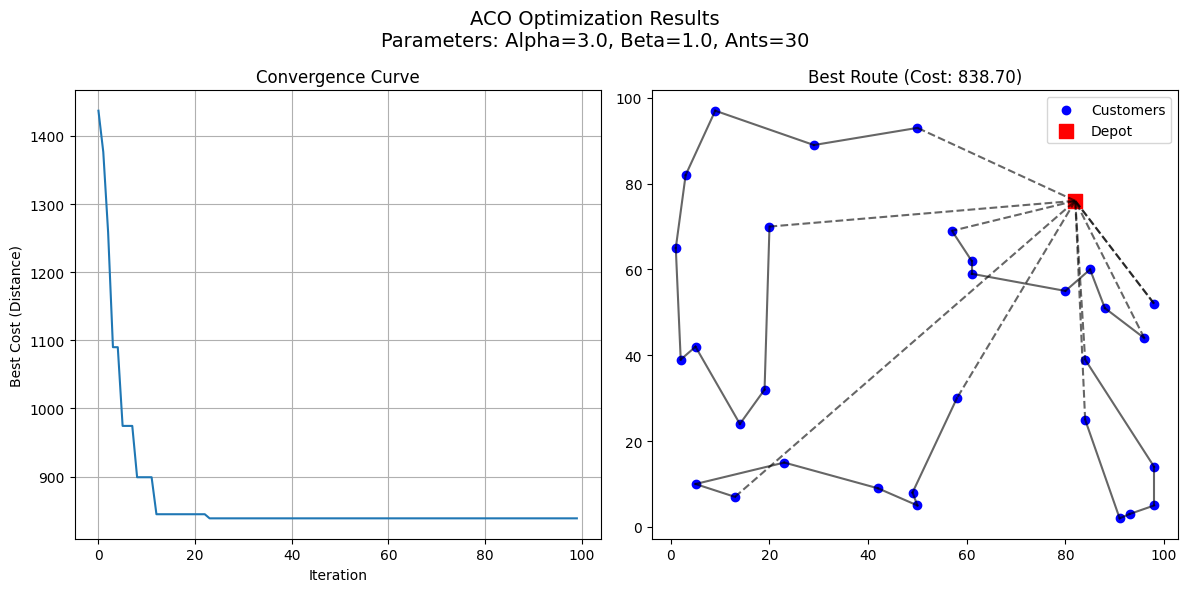

In [44]:
# --- Visualization with Parameters ---

plt.figure(figsize=(12, 6))

# Add a Super Title to show parameters on top of the image
plt.suptitle(f"ACO Optimization Results\nParameters: Alpha={alpha}, Beta={beta}, Ants={num_ants}", fontsize=14)

# Plot 1: Convergence (Cost improvement over iterations)
plt.subplot(1, 2, 1)
plt.plot(cost_history)
plt.title("Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best Cost (Distance)")
plt.grid(True)

# Plot 2: Best Tour Visualization
plt.subplot(1, 2, 2)
plt.title(f"Best Route (Cost: {best_global_cost:.2f})")

# Plot all nodes
# Customer nodes in Blue, Depot in Red
plt.scatter(nodes[1:, 0], nodes[1:, 1], c='blue', label='Customers')
plt.scatter(nodes[0, 0], nodes[0, 1], c='red', s=100, marker='s', label='Depot')

# Plot the path
tour = best_global_tour
for i in range(len(tour) - 1):
    u = tour[i]
    v = tour[i+1]
    
    # Draw line between u and v
    p1 = nodes[u]
    p2 = nodes[v]
    
    # If returning to depot, use a dashed line for visual clarity
    linestyle = '-'
    if u == 0 or v == 0:
        linestyle = '--'
        
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k', linestyle=linestyle, alpha=0.6)

plt.legend()
plt.tight_layout() # Adjust layout to make room for the suptitle
plt.show()

# Comparative Analysis of ACO Parameters for CVRP

In this section, we investigate the impact of the pheromone importance ($\alpha$) and heuristic information importance ($\beta$) on the performance of the Ant Colony Optimization (ACO) algorithm. We tested three different configurations on the `A-n32-k5` instance.

## 1. Summary of Results

The table below summarizes the best cost (total distance) found by the algorithm for each configuration after 100 iterations.

| Configuration              | Alpha ($\alpha$) | Beta ($\beta$) | **Best Cost** | Observation                                                     |
| :------------------------- | :--------------: | :------------: | :-----------: | :-------------------------------------------------------------- |
| **Scenario 1 (Balanced)**  |       1.0        |      2.0       |  **839.42**   | **Best performance.** Deep exploration found the shortest path. |
| **Scenario 2 (Greedy)**    |       1.0        |      5.0       |    944.07     | Trapped in local optimum due to greedy choices.                 |
| **Scenario 3 (Pheromone)** |       3.0        |      1.0       |    952.86     | Stagnated early. Too much reliance on past trails.              |

## 2. Analysis of Configurations

### Scenario 1: Balanced Approach ($\alpha=1, \beta=2$)

In this configuration, the ants balanced the influence of the pheromone trail and the heuristic distance.

- **Result:** The algorithm reached the lowest cost of **839.42**.
- **Behavior:** As seen in the blue line, the algorithm made a significant breakthrough around iteration 48, finding a much better route than the other configurations.

### Scenario 2: Greedy Approach ($\alpha=1, \beta=5$)

Here, ants prioritized the closest city (short-term gain) over the pheromone trails.

- **Result:** The cost is **944.07**.
- **Behavior:** It converged quickly initially but failed to improve significantly afterwards, getting stuck in a local optimum.

### Scenario 3: Pheromone-Heavy Approach ($\alpha=3, \beta=1$)

In this test, ants relied heavily on previous generations' paths.

- **Result:** Surprisingly, this yielded the highest cost of **952.86** in this run.
- **Behavior:** The high pheromone weight likely caused the colony to converge too early on a suboptimal path, preventing them from exploring other possibilities (Stagnation).

## 3. Conclusion

For this specific run on the `A-n32-k5` instance, the **Balanced parameters ($\alpha=1, \beta=2$)** proved to be the most robust, allowing the algorithm to escape local optima and find the global best solution.


Running comparative analysis...
Running Balanced (A=1, B=2)...
Running Greedy (A=1, B=5)...
Running Pheromone (A=3, B=1)...


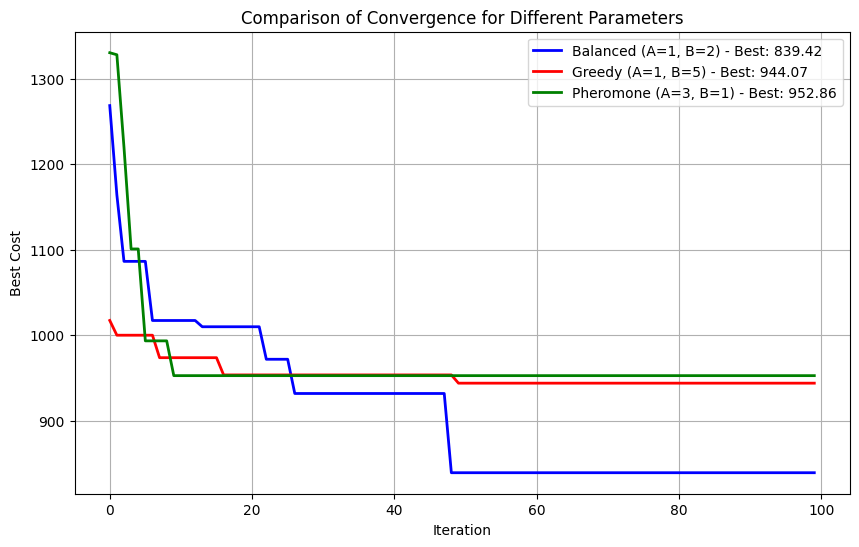

In [45]:
import matplotlib.pyplot as plt

scenarios = [
    {"name": "Balanced (A=1, B=2)", "alpha": 1.0, "beta": 2.0, "color": "blue"},
    {"name": "Greedy (A=1, B=5)",   "alpha": 1.0, "beta": 5.0, "color": "red"},
    {"name": "Pheromone (A=3, B=1)","alpha": 3.0, "beta": 1.0, "color": "green"}
]

plt.figure(figsize=(10, 6))
print("Running comparative analysis...")

for sc in scenarios:
    print(f"Running {sc['name']}...")
    
    pheromone = np.ones((len(nodes), len(nodes)))
    current_cost_history = []
    
    curr_alpha = sc['alpha']
    curr_beta = sc['beta']
    
    best_run_cost = float('inf')
    
    for iteration in range(num_iterations):
        ants = []
        for _ in range(num_ants):
            ant = Ant(len(nodes), capacity, demands)
            ant.run_tour(d_ij, pheromone, heuristic, curr_alpha, curr_beta)
            ants.append(ant)
            
        ants.sort(key=lambda x: x.total_cost)
        best_ant = ants[0]
        
        if best_ant.total_cost < best_run_cost:
            best_run_cost = best_ant.total_cost
            
        current_cost_history.append(best_run_cost)
        
        pheromone *= (1 - evaporation_rate)
        for ant in ants:
            deposit = Q / ant.total_cost
            for i in range(len(ant.tour) - 1):
                u, v = ant.tour[i], ant.tour[i+1]
                pheromone[u][v] += deposit
                pheromone[v][u] += deposit

    plt.plot(current_cost_history, label=f"{sc['name']} - Best: {best_run_cost:.2f}", color=sc['color'], linewidth=2)

plt.title("Comparison of Convergence for Different Parameters")
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.legend()
plt.grid(True)
plt.show()